In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
import os

# Suppress warnings
warnings.filterwarnings('ignore')

## data loading and finances

In [2]:
def load_and_enrich_data(filepath):
    """
    Loads raw data and calculates advanced financial metrics.
    """
    if not os.path.exists(filepath):
        print(f"Error: File '{filepath}' not found.")
        return None

    print("Loading and enriching dataset...")
    df = pd.read_csv(filepath)

    # A. Currency Conversion
    df['price_inr'] = df['price_usd'] * 87.0
    
    # B. Sentiment Encoding
    df['is_positive'] = df['sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)
    
    # C. Date Parsing
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['month_year'] = df['review_date'].dt.to_period('M')

    # D. Income Tier
    def get_income_tier(c):
        if c in ['USA', 'UK', 'Canada', 'Australia', 'Germany', 'UAE']: return 'High Income'
        if c in ['Brazil']: return 'Upper-Middle Income'
        return 'Lower-Middle Income'
    df['income_tier'] = df['country'].apply(get_income_tier)

    # E. Profit Margin Model
    def get_margin(row):
        base_margin = 0.10
        if row['brand'] in ['Xiaomi', 'Realme', 'OnePlus', 'Motorola', 'Vivo']:
            base_margin = 0.15
        if row['income_tier'] != 'High Income':
            base_margin += 0.02
        return base_margin
    df['margin_pct'] = df.apply(get_margin, axis=1)

    # F. Return Rate Model (Exponential Decay)
    quality_score = (0.7 * df['rating']) + (0.3 * df['is_positive'] * 5)
    df['return_rate'] = 0.02 + (0.18 * np.exp(-0.8 * (quality_score - 1)))
    
    # G. Net Profit
    df['gross_profit'] = df['price_inr'] * df['margin_pct']
    df['net_profit_unit'] = df['gross_profit'] - (df['price_inr'] * df['return_rate'] * 0.4)

    return df

## OHE and target def

In [3]:
def prepare_market_stats(df):
    """
    Aggregates data, applies One-Hot Encoding, and calculates Success Score.
    """
    print("Aggregating data and applying One-Hot Encoding...")
    
    market_stats = df.groupby(['country', 'model']).agg({
        'brand': 'first',
        'income_tier': 'first',
        'price_inr': 'mean',
        'age': 'mean',
        'battery_life_rating': 'mean',
        'camera_rating': 'mean',
        'performance_rating': 'mean',
        'net_profit_unit': 'mean',
        'return_rate': 'mean',
        'is_positive': 'mean',
        'review_id': 'count'
    }).reset_index()

    market_stats.rename(columns={'is_positive': 'sentiment', 'review_id': 'volume'}, inplace=True)

    # 1. Target Definition (Success Score 0-1)
    market_stats['norm_vol'] = market_stats.groupby('country')['volume'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    market_stats['norm_sent'] = market_stats.groupby('country')['sentiment'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    market_stats['success_score'] = (0.5 * market_stats['norm_vol']) + (0.5 * market_stats['norm_sent'])

    # 2. Ordinal Encoding for Income (Preserve Order: Low < Mid < High)
    income_map = {'Lower-Middle Income': 0, 'Upper-Middle Income': 1, 'High Income': 2}
    market_stats['income_enc'] = market_stats['income_tier'].map(income_map)

    # 3. One-Hot Encoding for Nominal Data (Brand, Country)
    # This prevents the "Apple < Samsung" mathematical fallacy
    market_stats = pd.get_dummies(market_stats, columns=['brand', 'country'], prefix=['brand', 'country'])

    # 4. Define Feature List (Dynamic)
    # We include all the new One-Hot columns automatically
    base_features = ['income_enc', 'price_inr', 'age', 'battery_life_rating', 
                     'camera_rating', 'net_profit_unit']
    
    # Add all generated dummy columns (e.g., brand_Apple, country_India)
    dummy_features = [col for col in market_stats.columns if col.startswith('brand_') or col.startswith('country_')]
    feature_cols = base_features + dummy_features
    
    return market_stats, feature_cols

## Visuals

Loading and enriching dataset...
Aggregating data and applying One-Hot Encoding...


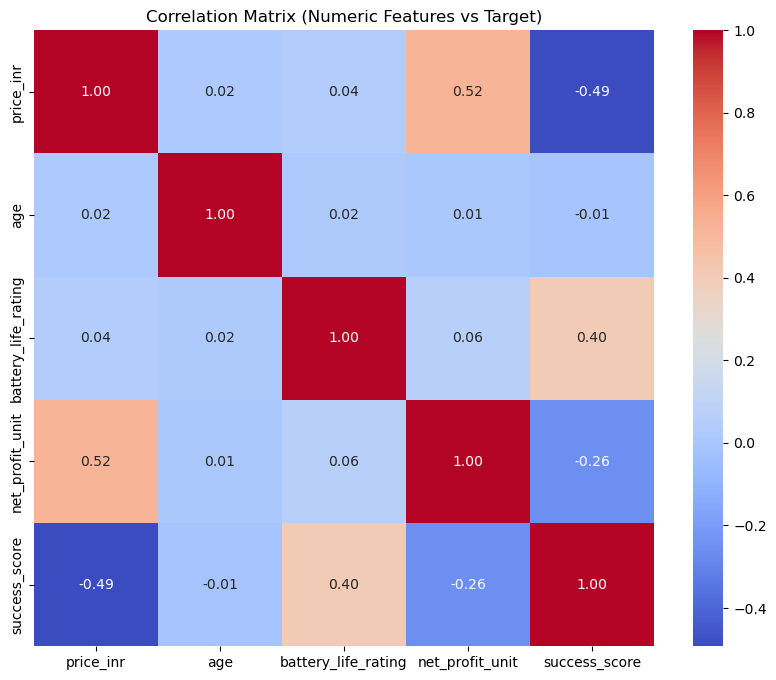

In [4]:
def show_correlation_matrix(market_stats, feature_cols):
    # Select a subset of features to keep the heatmap readable
    # We pick base features + target
    display_cols = ['price_inr', 'age', 'battery_life_rating', 'net_profit_unit', 'success_score']
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(market_stats[display_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix (Numeric Features vs Target)")
    plt.show()

# Run Setup
filepath = "Mobile Reviews Sentiment.csv"
if os.path.exists(filepath):
    raw_df = load_and_enrich_data(filepath)
    market_stats, feature_cols = prepare_market_stats(raw_df)
    show_correlation_matrix(market_stats, feature_cols)

## hyperparameter tuning

In [5]:
def tune_brain(market_stats, feature_cols):
    """
    Finds optimal settings for RandomForestRegressor.
    """
    print("\n" + "="*40)
    print("🔧 HYPERPARAMETER TUNING")
    print("="*40)
    
    X = market_stats[feature_cols]
    y = market_stats['success_score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    rf = RandomForestRegressor(random_state=42)
    
    print(f"Testing combinations on {len(feature_cols)} features (including One-Hot vars)...")
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=3, n_jobs=-1, scoring='r2', verbose=1)
    
    grid_search.fit(X_train, y_train)
    
    print(f"\n✅ Best Parameters: {grid_search.best_params_}")
    print(f"✅ Best R² Score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_params_

# Execute
best_params = tune_brain(market_stats, feature_cols)


🔧 HYPERPARAMETER TUNING
Testing combinations on 21 features (including One-Hot vars)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
✅ Best R² Score: 0.5690


## final training

In [6]:
def train_final_system(market_stats, raw_df, feature_cols, best_params):
    print("🧠 Training Final System (Regressor)...")
    
    # 1. Train RF Regressor
    rf_final = RandomForestRegressor(**best_params, random_state=42)
    rf_final.fit(market_stats[feature_cols], market_stats['success_score'])

    # 2. Build Global Hardware KNN (Same as before - based on specs, not brand)
    global_specs = raw_df.groupby('model').agg({
        'price_inr': 'mean',
        'battery_life_rating': 'mean',
        'camera_rating': 'mean',
        'performance_rating': 'mean'
    }).reset_index()
    
    knn_cols = ['price_inr', 'battery_life_rating', 'camera_rating', 'performance_rating']
    scaler = StandardScaler()
    X_global = scaler.fit_transform(global_specs[knn_cols])
    
    knn_global = NearestNeighbors(n_neighbors=10, metric='euclidean')
    knn_global.fit(X_global)
    
    return rf_final, scaler, global_specs, knn_global

# Train
rf, scaler, global_specs, knn_global = train_final_system(market_stats, raw_df, feature_cols, best_params)

🧠 Training Final System (Regressor)...


## forecasting logic

In [7]:
def get_forecast(model_name, raw_df):
    sales = raw_df[raw_df['model'] == model_name].groupby('month_year').size()
    if len(sales) < 12: return sales.mean(), sales
    try:
        model = ExponentialSmoothing(sales.values.astype(float), 
                                     trend='add', seasonal=None, damped_trend=True)
        fit = model.fit()
        return max(0, fit.forecast(1)[0]), sales
    except:
        return sales.mean(), sales

## recomendation logic

In [8]:
def generate_stocking_plan(target_age, target_country, budget, total_units, 
                           rf_model, scaler, market_stats, feature_cols, raw_df, global_specs, knn_global, banned_models=[]):
    
    # 1. Filter
    candidates = market_stats[
        (market_stats[f'country_{target_country}'] == 1) &  # Filter using One-Hot Column
        (market_stats['price_inr'] <= budget)
    ].copy()

    if candidates.empty: return None

    # 2. AI Scoring
    candidates['age'] = target_age 
    candidates['ai_score'] = rf_model.predict(candidates[feature_cols])
    
    # 3. Harmonic Score
    max_p = candidates['net_profit_unit'].max()
    candidates['norm_profit'] = candidates['net_profit_unit'] / max_p
    eps = 1e-9
    candidates['final_score'] = 2 * (candidates['ai_score'] * candidates['norm_profit']) / \
                                (candidates['ai_score'] + candidates['norm_profit'] + eps)

    candidates = candidates.sort_values(by='final_score', ascending=False)

    # 4. Substitution Logic
    final_list = []
    knn_cols = ['price_inr', 'battery_life_rating', 'camera_rating', 'performance_rating']

    for idx, row in candidates.iterrows():
        if len(final_list) >= 5: break
        m_name = row['model']
        
        if m_name in banned_models:
            print(f"Model '{m_name}' unavailable. Searching Global Specs...")
            target_spec_row = global_specs[global_specs['model'] == m_name]
            target_vec = scaler.transform(target_spec_row[knn_cols].values) if not target_spec_row.empty \
                         else scaler.transform([row[knn_cols].values])

            dists, indices = knn_global.kneighbors(target_vec)
            found = False
            for i in indices[0]:
                alt_name = global_specs.iloc[i]['model']
                
                # Check Local Availability using One-Hot Column
                is_available_locally = not market_stats[
                    (market_stats[f'country_{target_country}'] == 1) & 
                    (market_stats['model'] == alt_name)
                ].empty
                
                if (alt_name not in banned_models) and \
                   (alt_name not in [x['model'] for x in final_list]) and \
                   is_available_locally:
                    
                    local_data = market_stats[
                        (market_stats[f'country_{target_country}'] == 1) & 
                        (market_stats['model'] == alt_name)
                    ].iloc[0]
                    
                    print(f"   Swapped with: {alt_name}")
                    new_entry = row.copy()
                    new_entry['model'] = alt_name
                    new_entry['price_inr'] = local_data['price_inr']
                    new_entry['net_profit_unit'] = local_data['net_profit_unit']
                    new_entry['is_substitute'] = True
                    final_list.append(new_entry)
                    found = True
                    break
            if not found: print(f"   No substitute found for {m_name}.")
        else:
            row['is_substitute'] = False
            final_list.append(row)

    # 5. Finalize
    res = pd.DataFrame(final_list)
    res['forecast'] = res['model'].apply(lambda x: get_forecast(x, raw_df)[0])
    
    total_f = res['forecast'].sum()
    if total_f == 0: total_f = 1
    
    res['pct_sales'] = res['forecast'] / total_f
    res['suggested_qty'] = (res['pct_sales'] * total_units).astype(int)
    res['total_profit'] = res['suggested_qty'] * res['net_profit_unit']
    
    return res

In [9]:
## main


 AI INVENTORY MANAGER
Available Countries: Australia, Brazil, Canada, Germany, India, UAE, UK, USA


Target Country (Default: India):  UAE
Target Age:  30
Budget (INR):  90000
Total Units:  200



STOCKING PLAN FOR UAE
| Model           | AI Score   | % Sales   | Harmonic Score   | Qty   | Total Profit   |
|:----------------|:-----------|:----------|:-----------------|:------|:---------------|
| Realme 12 Pro   | 0.74       | 24.5%     | 0.655            | 48    | ₹1,90,775      |
| Realme Narzo 70 | 0.65       | 26.4%     | 0.618            | 52    | ₹2,05,225      |
| Redmi Note 13   | 0.5        | 16.8%     | 0.575            | 33    | ₹1,51,948      |
| OnePlus 11R     | 0.41       | 14.3%     | 0.574            | 28    | ₹1,83,240      |
| Pixel 7a        | 0.49       | 18.1%     | 0.572            | 36    | ₹1,64,386      |



Remove Model (or Enter to Finish):  OnePlus 11R


Model 'OnePlus 11R' unavailable. Searching Global Specs...
   Swapped with: Moto G Power

STOCKING PLAN FOR UAE
| Model           | AI Score   | % Sales   | Harmonic Score   | Qty   | Total Profit   |
|:----------------|:-----------|:----------|:-----------------|:------|:---------------|
| Realme 12 Pro   | 0.74       | 23.7%     | 0.655            | 47    | ₹1,86,801      |
| Realme Narzo 70 | 0.65       | 25.6%     | 0.618            | 51    | ₹2,01,278      |
| Redmi Note 13   | 0.5        | 16.3%     | 0.575            | 32    | ₹1,47,344      |
| Moto G Power    | 0.41       | 16.8%     | 0.574            | 33    | ₹1,68,341      |
| Pixel 7a        | 0.49       | 17.5%     | 0.572            | 35    | ₹1,59,819      |



Remove Model (or Enter to Finish):  


Finalizing...


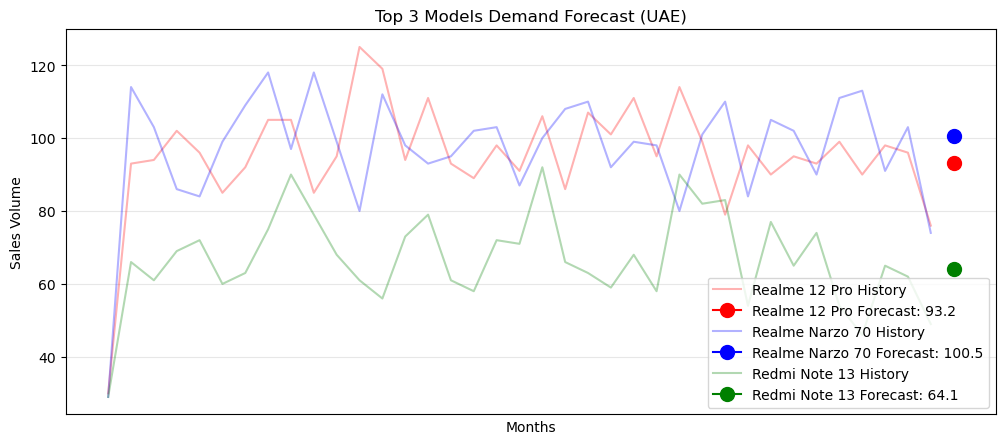

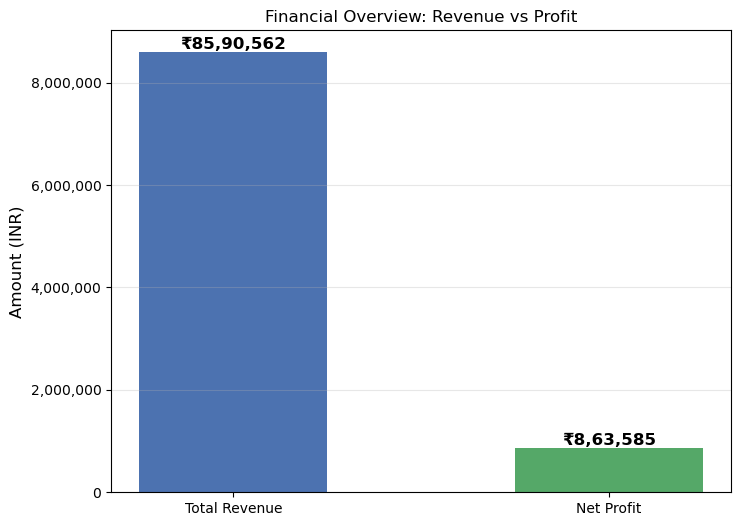

In [10]:
# === FINAL EXECUTION BLOCK ===
# Helper: Indian Number Formatting
def format_indian(n):
    n = int(n)
    s = str(n)
    if len(s) <= 3: return f"₹{s}"
    last_three = s[-3:]
    remaining = s[:-3]
    groups = []
    while remaining:
        groups.append(remaining[-2:])
        remaining = remaining[:-2]
    groups.reverse()
    formatted = ",".join(groups) + "," + last_three
    return f"₹{formatted}"

print("\n" + "="*50)
print(" AI INVENTORY MANAGER")
print("="*50)

# 1. Inputs
# Get available countries from the dummy columns
avail_countries = [c.replace('country_', '') for c in market_stats.columns if c.startswith('country_')]
avail_countries = sorted(list(set(avail_countries)))
print(f"Available Countries: {', '.join(avail_countries)}")

u_country = input("Target Country (Default: India): ").strip() or "India"
if u_country not in avail_countries: 
    print("Country not found. Using 'India'."); u_country="India"

try:
    u_age = int(input("Target Age: "))
    u_budget = float(input("Budget (INR): "))
    u_units = int(input("Total Units: "))
except ValueError:
    print("Invalid numbers. Using defaults.")
    u_age, u_budget, u_units = 25, 40000, 500

banned = []

# 2. Loop
while True:
    plan = generate_stocking_plan(u_age, u_country, u_budget, u_units, 
                                  rf, scaler, market_stats, feature_cols, raw_df, global_specs, knn_global, banned)
    
    if plan is None: print("No matching phones."); break

    # 3. Display
    print(f"\nSTOCKING PLAN FOR {u_country.upper()}")
    view = plan[['model', 'ai_score', 'pct_sales', 'final_score', 'suggested_qty', 'total_profit']].copy()
    view['ai_score'] = view['ai_score'].apply(lambda x: f"{x:.2f}")
    view['pct_sales'] = view['pct_sales'].apply(lambda x: f"{x:.1%}")
    view['final_score'] = view['final_score'].apply(lambda x: f"{x:.3f}")
    view['total_profit'] = view['total_profit'].apply(format_indian)
    view.columns = ['Model', 'AI Score', '% Sales', 'Harmonic Score', 'Qty', 'Total Profit']
    
    try:
        print(view.to_markdown(index=False, numalign="left", stralign="left"))
    except:
        print(view.to_string(index=False))

    # 4. Modification
    cmd = input("\nRemove Model (or Enter to Finish): ").strip()
    if cmd == "":
        print("Finalizing...")
        
        # Graph 1: Forecast
        top_3 = plan.head(3)
        colors = ['red', 'blue', 'green']
        plt.figure(figsize=(12, 5))
        for i, (idx, row) in enumerate(top_3.iterrows()):
            model_name = row['model']
            pred, hist = get_forecast(model_name, raw_df)
            color = colors[i % len(colors)]
            plt.plot(hist.index.astype(str), hist.values, color=color, alpha=0.3, label=f'{model_name} History')
            next_step = len(hist)
            plt.plot(next_step, pred, marker='o', color=color, markersize=10, 
                     label=f'{model_name} Forecast: {pred:.1f}')
        plt.title(f"Top 3 Models Demand Forecast ({u_country})")
        plt.xlabel("Months"); plt.ylabel("Sales Volume"); plt.xticks([]); plt.legend()
        plt.grid(True, alpha=0.3); plt.show()

        # Graph 2: Financials (Single Scale)
        total_revenue = (plan['price_inr'] * plan['suggested_qty']).sum()
        total_profit_val = plan['total_profit'].sum()
        fig, ax = plt.subplots(figsize=(8, 6))
        bars = ax.bar(['Total Revenue', 'Net Profit'], 
                      [total_revenue, total_profit_val], 
                      color=['#4c72b0', '#55a868'], width=0.5)
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, format_indian(height),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax.set_ylabel('Amount (INR)', fontsize=12)
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title("Financial Overview: Revenue vs Profit")
        plt.grid(axis='y', alpha=0.3); plt.show()
        break
    else:
        match = [m for m in plan['model'] if m.lower() == cmd.lower()]
        if match: banned.append(match[0])
        else: print("Model not found.")

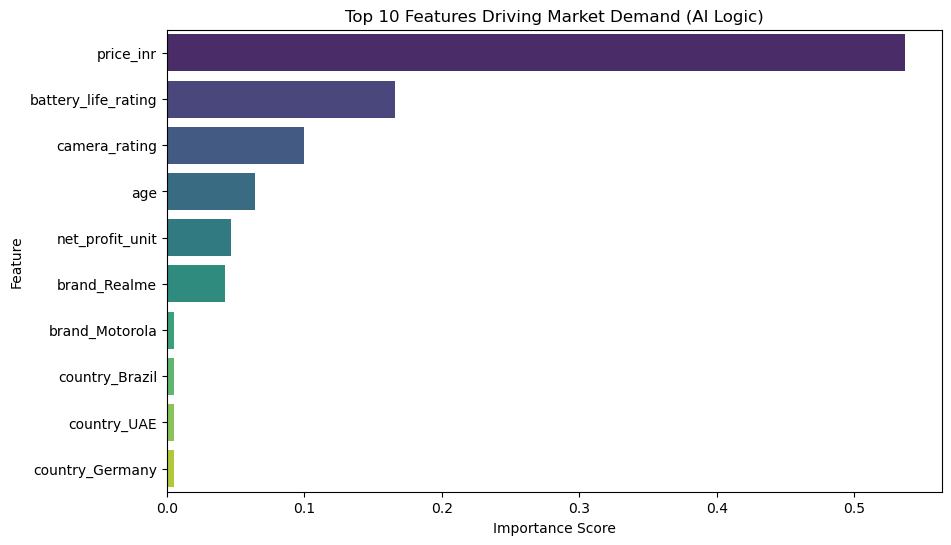

Exception ignored in: <function ResourceTracker.__del__ at 0x108239bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110065bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104041bc0>
Traceback (most recent call last

In [11]:
# === ADD THIS FOR THE PRESENTATION ===
def show_feature_importance(rf_model, feature_names):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Get importance
    importances = rf_model.feature_importances_
    
    # Create DataFrame
    feature_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_imp = feature_imp.sort_values(by='Importance', ascending=False).head(10) # Top 10 only

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
    plt.title('Top 10 Features Driving Market Demand (AI Logic)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

# Call it immediately after training
show_feature_importance(rf, feature_cols)